# Subtitle detection from photo

## 이미지 불러오기

총 2개의 이미지 파일을 찾았습니다.


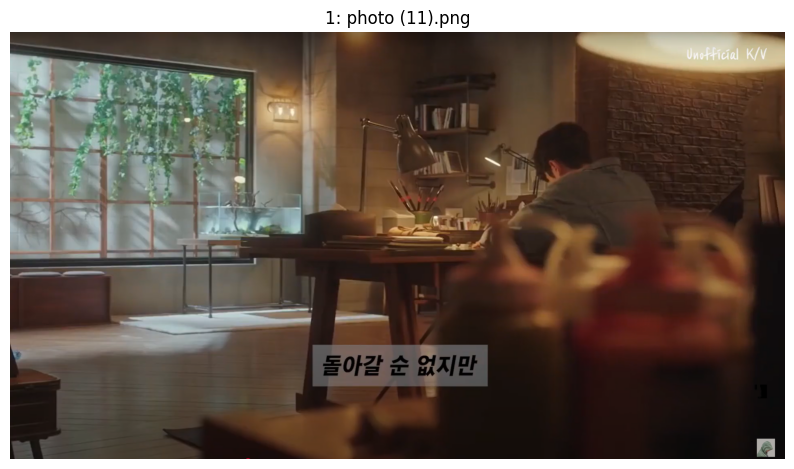

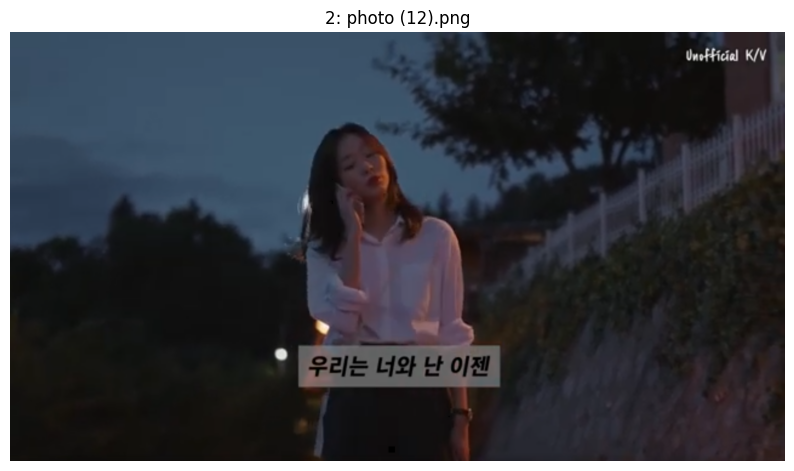

In [2]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os

# sample_photos 폴더 내 모든 이미지 파일 경로 리스트로 가져오기
photo_folder = './sample_photos'
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
photo_list = [
    os.path.join(photo_folder, fname)
    for fname in os.listdir(photo_folder)
    if fname.lower().endswith(image_extensions)
]

print(f"총 {len(photo_list)}개의 이미지 파일을 찾았습니다.")

# photo_list에 있는 이미지 하나씩 불러와서 모두 출력
for idx, img_path in enumerate(photo_list):
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title(f"{idx+1}: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

## Crop 영역 지정


===== 1/2 : photo (11).png =====


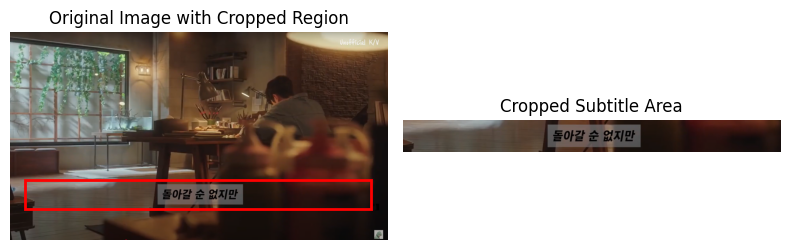


===== 2/2 : photo (12).png =====


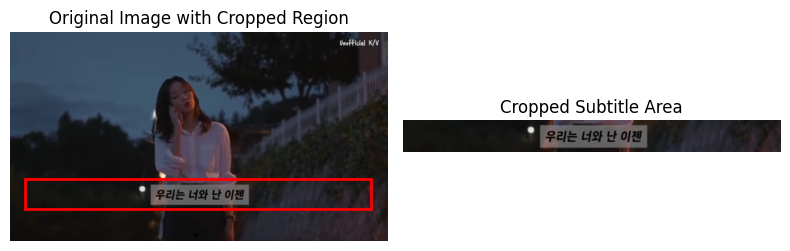

In [3]:
def process_image(img_path):
    # 1. 이미지 불러오기
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 2. Crop 영역 지정
    top = 1000
    bottom = 1200
    left = 100
    right = 2450
    crop_width = right - left
    crop_height = bottom - top
    cropped_image = image_rgb[top:bottom, left:right]

    # 3. 시각화 (원본+crop)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image_rgb)
    rect = patches.Rectangle((left, top), crop_width, crop_height,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title("Original Image with Cropped Region")
    ax1.axis('off')
    ax2.imshow(cropped_image)
    ax2.set_title("Cropped Subtitle Area")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

    # 이후 자막 인식 등 필요한 추가 코드도 여기에 넣으면 됩니다.
    # 예시: return cropped_image
    return cropped_image

cropped_images = []  # 모든 crop 이미지를 저장할 리스트

for idx, img_path in enumerate(photo_list):
    print(f"\n===== {idx+1}/{len(photo_list)} : {os.path.basename(img_path)} =====")
    cropped_image = process_image(img_path)
    cropped_images.append(cropped_image)  # 리스트에 추가
    # 이후 cropped_image를 활용한 추가 처리(자막 인식 등)도 반복문 안에서 수행

## 자막 인식 - 1


===== Cropped Image 1/2 =====
Target Color (RGB): [4 0 0]


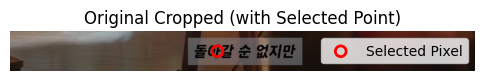

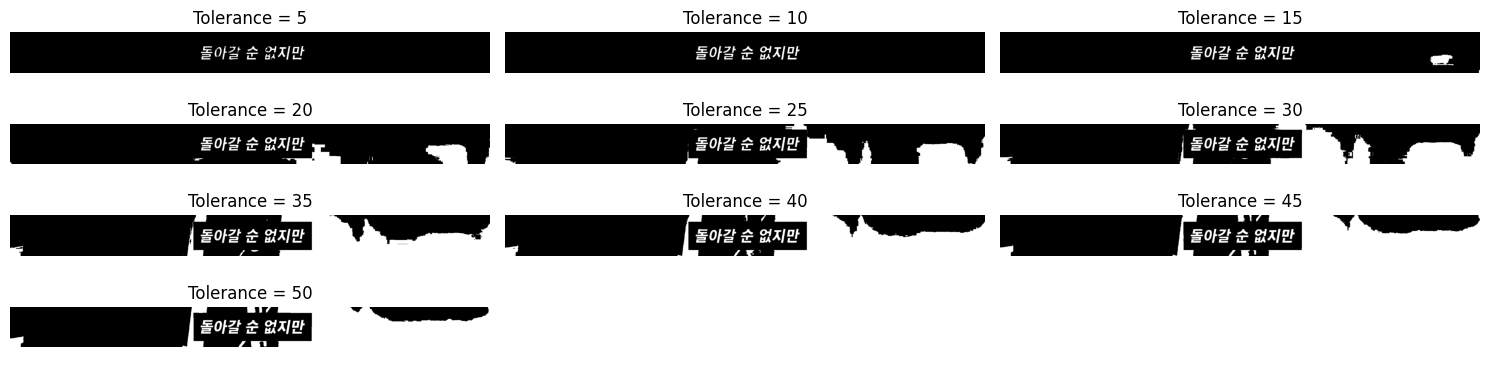


===== Cropped Image 2/2 =====
Target Color (RGB): [8 4 3]


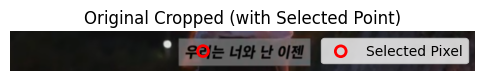

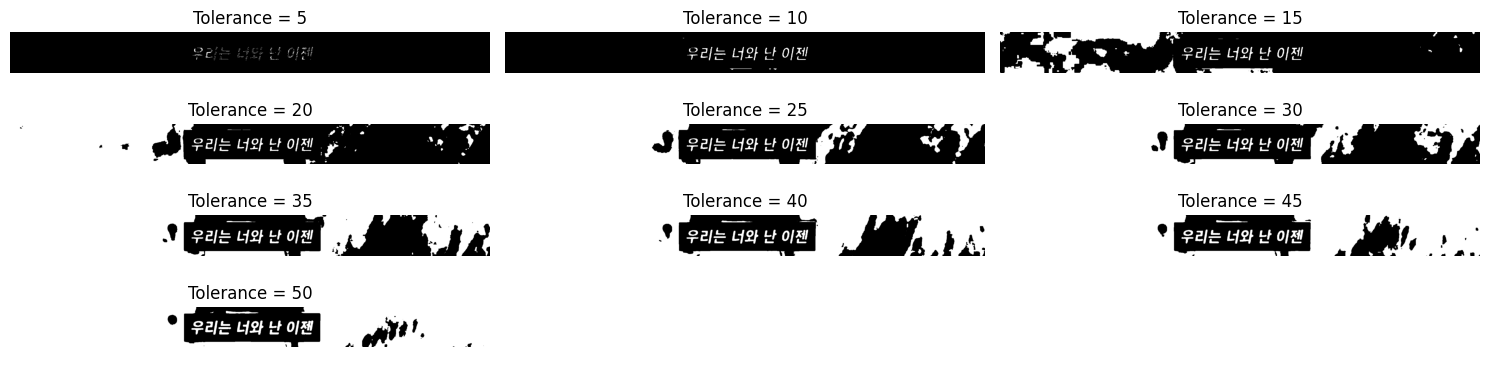

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def highlight_subtitle_area(cropped_image, y=100, x=1048, tolerances=range(5, 51, 5)):
    target_color = cropped_image[y, x].astype(int)

    highlighted_image_results = []
    for tolerance in tolerances:
        lower = np.array([max(0, c - tolerance) for c in target_color])
        upper = np.array([min(255, c + tolerance) for c in target_color])

        cropped_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
        lower_bgr = np.array([lower[2], lower[1], lower[0]])
        upper_bgr = np.array([upper[2], upper[1], upper[0]])
        mask = cv2.inRange(cropped_bgr, lower_bgr, upper_bgr)

        highlighted_image = np.full_like(cropped_image, 0)
        highlighted_image[mask == 255] = [255, 255, 255]

        highlighted_image_results.append({
            "tolerance": tolerance,
            "highlighted_image": highlighted_image.copy(),
            "mask": mask.copy(),
            "white_pixel_count": np.sum(mask == 255),
            "target_color": target_color
        })
    return highlighted_image_results

target_pixel_list = [(100, 1048), (99, 975)]

for idx, cropped_image in enumerate(cropped_images):
    print(f"\n===== Cropped Image {idx+1}/{len(cropped_images)} =====")
    y, x = target_pixel_list[idx]
    target_color = cropped_image[y, x].astype(int)
    print(f"Target Color (RGB): {target_color}")

    # 원본 크롭 이미지 + 점 표시
    plt.figure(figsize=(6, 5))
    plt.imshow(cropped_image)
    plt.scatter(x, y, s=60, facecolors='none', edgecolors='red', linewidths=2, marker='o', label='Selected Pixel')
    plt.title("Original Cropped (with Selected Point)")
    plt.axis('off')
    plt.legend(loc='upper right')
    plt.show()

    highlighted_image_results = highlight_subtitle_area(cropped_image, y, x)

    # subplot으로 한 번에 시각화
    n = len(highlighted_image_results)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 1*nrows))
    axes = axes.flatten()
    for i, result in enumerate(highlighted_image_results):
        axes[i].imshow(result["highlighted_image"])
        axes[i].set_title(f"Tolerance = {result['tolerance']}")
        axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

## 자막 인식 - 2

10개의 tolerance에 대해 psm 6 8 10의 방식으로 coef를 조절해 각 이미지별로 총 90번의 bounding box detection을 진행
detection된 bounding box를 이미지에 표시하고, 이를 list에 정리

In [ ]:
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# ...existing code...

def ocr_highlighted_images(highlighted_image_results):
    conf_thresholds = [0, 10, 50]
    psm_modes = {
        "psm6": '--oem 3 --psm 6 -l kor+eng',
        "psm8": '--oem 3 --psm 8 -l kor+eng',
        "psm10": '--oem 3 --psm 10 -l kor+eng'
    }
    all_detected_boxes = []  # 모든 box 정보 저장

    for result in highlighted_image_results:
        highlighted_image = result["highlighted_image"]
        tolerance = result["tolerance"]

        gray = cv2.cvtColor(highlighted_image, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0.01)
        _, binary = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)
        dilated = cv2.dilate(binary, np.ones((2, 2), np.uint8), iterations=1)

        image_height, image_width = dilated.shape

        for conf_threshold in conf_thresholds:
            for label, config in psm_modes.items():
                results = pytesseract.image_to_data(dilated, output_type=Output.DICT, config=config)
                n_boxes = len(results['level'])
                for i in range(n_boxes):
                    text = results['text'][i].strip()
                    conf = int(results['conf'][i])
                    x = results['left'][i]
                    y = results['top'][i]
                    w = results['width'][i]
                    h = results['height'][i]

                    if (conf > conf_threshold and text != '' and
                        x > 0 and y > 0 and x + w < image_width and y + h < image_height):

                        # box 정보 저장
                        all_detected_boxes.append({
                            "tolerance": tolerance,
                            "psm": label,
                            "conf_threshold": conf_threshold,
                            "x": x,
                            "y": y,
                            "w": w,
                            "h": h,
                            "conf": conf,
                            "text": text
                        })
    return all_detected_boxes

# 이미지별로 모든 box 정보 저장
all_boxes_per_image = []

for idx, cropped_image in enumerate(cropped_images):
    y, x = target_pixel_list[idx]
    highlighted_image_results = highlight_subtitle_area(cropped_image, y=y, x=x)
    detected_boxes = ocr_highlighted_images(highlighted_image_results)
    all_boxes_per_image.append(detected_boxes)
    print(f"\n===== Cropped Image {idx+1}/{len(cropped_images)} =====")
    target_color = cropped_image[y, x].astype(int)
    print(f"Target Color (RGB): {target_color}")
    print(f"Detected {len(detected_boxes)} boxes in this image.")


===== Cropped Image 1/2 =====
Target Color (RGB): [4 0 0]
Detected 101 boxes in this image.

===== Cropped Image 1/2 =====
Target Color (RGB): [4 0 0]

===== Cropped Image 2/2 =====
Target Color (RGB): [8 4 3]
Detected 170 boxes in this image.

===== Cropped Image 2/2 =====
Target Color (RGB): [8 4 3]


# 인식한 bounding box의 y축 길이 histogram

cell 9에서 인식한 box에 대해 각 box의 y축 길이를 표현하는 histogram을 그림
이후 최빈 bin에 속하는 box list를 다시 저장한다

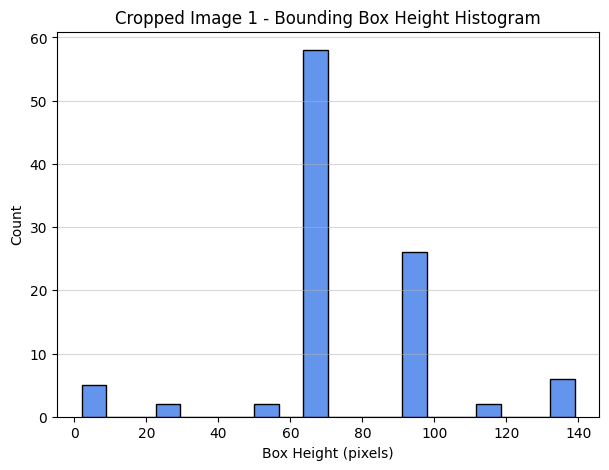

Cropped Image 1: 최빈 bin box 개수 = 58 (bin: 63.6 ~ 70.5)


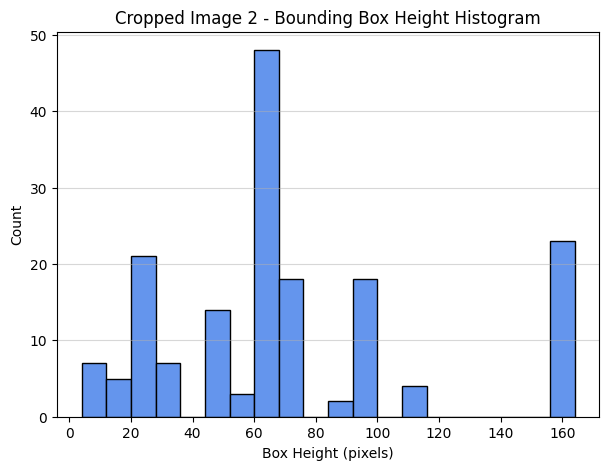

Cropped Image 2: 최빈 bin box 개수 = 48 (bin: 60.0 ~ 68.0)


In [72]:
# Cell: 인식한 bounding box의 y축 길이 histogram

# cell 9에서 인식한 box 리스트: all_boxes_per_image (각 이미지별 box dict list)
# 각 box의 y축 길이(h)를 histogram으로 시각화하고, 최빈 bin에 속하는 box만 추출

mode_boxes_all = []  # 이미지별 최빈 bin box 리스트 저장

for idx, boxes in enumerate(all_boxes_per_image):
    heights = [box["h"] for box in boxes]
    if not heights:
        print(f"Cropped Image {idx+1}: 인식된 box 없음")
        mode_boxes_all.append([])
        continue

    # 히스토그램 그리기
    plt.figure(figsize=(7, 5))
    n, bins, patches = plt.hist(heights, bins=20, color='cornflowerblue', edgecolor='black')
    plt.title(f"Cropped Image {idx+1} - Bounding Box Height Histogram")
    plt.xlabel("Box Height (pixels)")
    plt.ylabel("Count")
    plt.grid(True, axis='y', alpha=0.5)
    plt.show()

    # 최빈 bin 찾기
    max_bin_idx = n.argmax()
    bin_left = bins[max_bin_idx]
    bin_right = bins[max_bin_idx + 1]

    # 최빈 bin에 속하는 box만 추출
    mode_boxes = [box for box in boxes if bin_left <= box["h"] < bin_right]
    mode_boxes_all.append(mode_boxes)
    print(f"Cropped Image {idx+1}: 최빈 bin box 개수 = {len(mode_boxes)} (bin: {bin_left:.1f} ~ {bin_right:.1f})")

# 인식한 box x축 histogram & 최종 bounding box

cell 11에서 저장한 최빈_bin_box list를 활용해 x축 histogram을 그린다.
이때, box의 왼쪽 끝과 오른쪽 끝의 x 위치값(box 별로 2개씩)을 histogram에 표현한다.

개수가 sample 수/5 보다 큰 bin만 다시 box를 filtered_boxes_all list에 정리한다
filtering된 박스에 대해서 해당 박스들을 포괄하는 최종 bounding box를 구해 list에 저장하고, 각 이미지에 표시해 보여준다

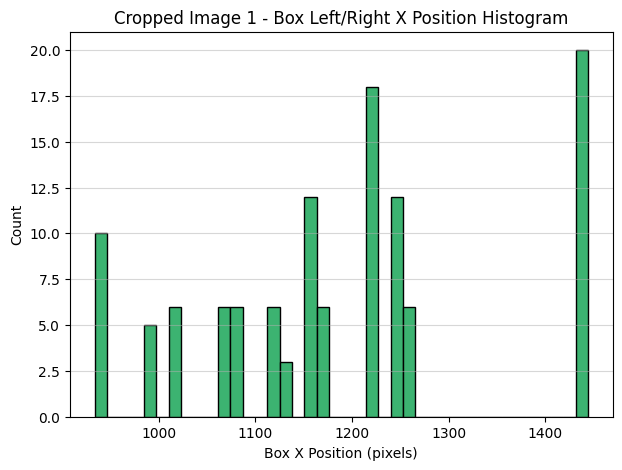

Cropped Image 1: threshold=5.8, 필터링된 box 개수=58


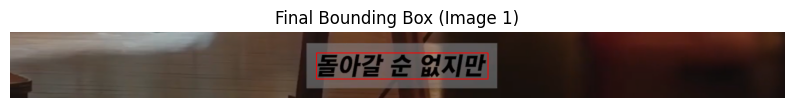

Cropped Image 1: 최종 bounding box = (929, 63), (1449, 142)


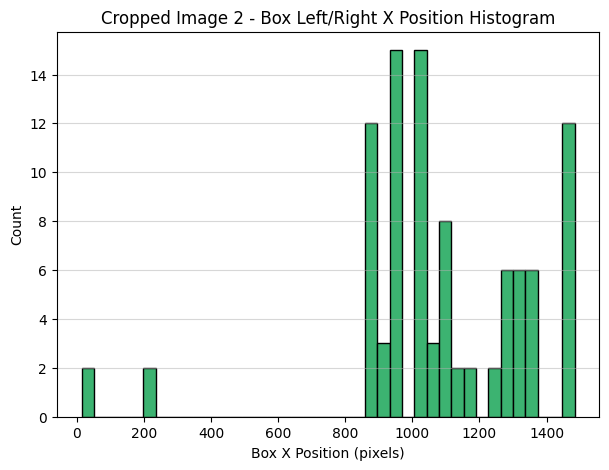

Cropped Image 2: threshold=4.8, 필터링된 box 개수=44


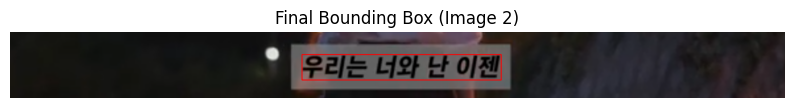

Cropped Image 2: 최종 bounding box = (885, 68), (1489, 145)


In [88]:
# cell 13: x축 histogram 및 최종 bounding box 계산/시각화

final_bounding_boxes = []  # 각 이미지별 최종 bounding box 좌표 저장
margin = 5  # box 주변 여백 (픽셀 단위)

for idx, mode_boxes in enumerate(mode_boxes_all):
    x_edges = []
    for box in mode_boxes:
        x_left = box["x"]
        x_right = box["x"] + box["w"]
        x_edges.extend([x_left, x_right])
    if not x_edges:
        print(f"Cropped Image {idx+1}: 최빈 bin box 없음")
        final_bounding_boxes.append(None)
        continue

    # x축 histogram
    plt.figure(figsize=(7, 5))
    n, bins, patches = plt.hist(x_edges, bins=40, color='mediumseagreen', edgecolor='black')
    plt.title(f"Cropped Image {idx+1} - Box Left/Right X Position Histogram")
    plt.xlabel("Box X Position (pixels)")
    plt.ylabel("Count")
    plt.grid(True, axis='y', alpha=0.5)
    plt.show()

    # sample 수 = len(x_edges)//2 (box별로 2개씩 넣었으므로)
    sample_count = len(x_edges) // 2
    threshold = sample_count / 10

    # threshold를 넘는 bin의 범위 찾기
    filtered_boxes = []
    for bin_idx, count in enumerate(n):
        if count > threshold:
            bin_left = bins[bin_idx]
            bin_right = bins[bin_idx + 1]
            for box in mode_boxes:
                x_left = box["x"]
                x_right = box["x"] + box["w"]
                if (bin_left <= x_left < bin_right) or (bin_left <= x_right < bin_right):
                    filtered_boxes.append(box)
    # 중복 제거
    filtered_boxes = list({id(box): box for box in filtered_boxes}.values())
    print(f"Cropped Image {idx+1}: threshold={threshold:.1f}, 필터링된 box 개수={len(filtered_boxes)}")

    # 최종 bounding box 계산
    if filtered_boxes:
        x_min = min(box["x"] for box in filtered_boxes) - margin
        y_min = min(box["y"] for box in filtered_boxes) - margin
        x_max = max(box["x"] + box["w"] for box in filtered_boxes) + margin
        y_max = max(box["y"] + box["h"] for box in filtered_boxes) + margin
        # bounding box 좌표 보정
        final_bounding_boxes.append((x_min, y_min, x_max, y_max))
        # 시각화
        boxed_image = cropped_images[idx].copy()
        cv2.rectangle(boxed_image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
        plt.figure(figsize=(10, 5))
        plt.imshow(boxed_image)
        plt.title(f"Final Bounding Box (Image {idx+1})")
        plt.axis('off')
        plt.show()
        print(f"Cropped Image {idx+1}: 최종 bounding box = ({x_min}, {y_min}), ({x_max}, {y_max})")
    else:
        final_bounding_boxes.append(None)
        print(f"Cropped Image {idx+1}: 조건에 맞는 box 없음")

# 최종 자막 detect - 자막

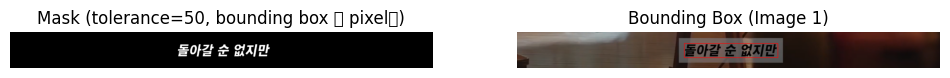

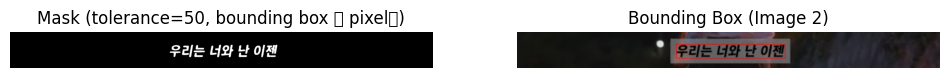

In [90]:
# Cell 7: tolerance=50만 사용, cell 13에서 구한 bounding box 내 pixel만 포함
for idx, cropped_image in enumerate(cropped_images):
    y, x = target_pixel_list[idx]
    # tolerance=50만 사용
    highlight_result = highlight_subtitle_area(cropped_image, y=y, x=x, tolerances=[50])[0]
    mask = highlight_result["mask"]


    # 아래는 bounding_boxes[idx]를 사용한다고 가정
    x_min, y_min, x_max, y_max = final_bounding_boxes[idx]

    # bounding box 내 pixel만 포함하는 mask 생성
    mask_bbox = np.zeros_like(mask)
    mask_bbox[y_min:y_max, x_min:x_max] = mask[y_min:y_max, x_min:x_max]

    # 시각화
    boxed_image = cropped_image.copy()
    cv2.rectangle(boxed_image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_bbox, cmap='gray')
    plt.title(f"Mask (tolerance=50, bounding box 내 pixel만)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(boxed_image)
    plt.title(f"Bounding Box (Image {idx+1})")
    plt.axis('off')
    plt.show()

# 최종 Detect - Bounding Box

cell 13에서 구한 final_bounding_boxes의 상하좌우 변을 기준으로 확장해가며 gradient가 급작스럽게 변하는 부분을 detection 진행
이를 이미지에 시각화한다

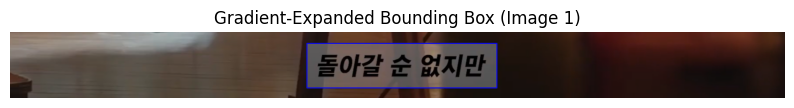

Cropped Image 1: 확장 bounding box = (900, 34), (1476, 169)


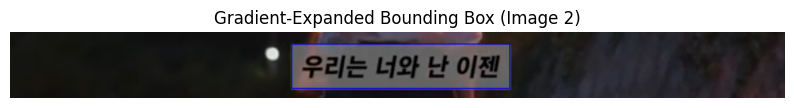

Cropped Image 2: 확장 bounding box = (854, 36), (1515, 170)


In [91]:
# cell: Gradient 기반 bounding box 확장 및 시각화

for idx, cropped_image in enumerate(cropped_images):
    if final_bounding_boxes[idx] is None:
        print(f"Cropped Image {idx+1}: bounding box 없음")
        continue

    x_min, y_min, x_max, y_max = final_bounding_boxes[idx]
    gray_crop = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

    # 초기 bounding box
    box_x, box_y = x_min, y_min
    box_w = x_max - x_min
    box_h = y_max - y_min

    # Sobel 연산으로 gradient 계산
    sobel_x = cv2.Sobel(gray_crop, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_crop, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    max_expand = 40
    gradient_threshold = 60

    expand_top = expand_bottom = expand_left = expand_right = 0

    # 위쪽 확장
    for i in range(1, max_expand):
        y = box_y - i
        if y < 0: break
        grad_line = gradient_magnitude[y, box_x:box_x + box_w]
        if np.mean(grad_line) >= gradient_threshold:
            expand_top = i
            break

    # 아래쪽 확장
    for i in range(1, max_expand):
        y = box_y + box_h + i
        if y >= gray_crop.shape[0]: break
        grad_line = gradient_magnitude[y, box_x:box_x + box_w]
        if np.mean(grad_line) >= gradient_threshold:
            expand_bottom = i
            break

    # 왼쪽 확장
    for i in range(1, max_expand):
        x = box_x - i
        if x < 0: break
        grad_line = gradient_magnitude[box_y:box_y + box_h, x]
        if np.mean(grad_line) >= gradient_threshold:
            expand_left = i
            break

    # 오른쪽 확장
    for i in range(1, max_expand):
        x = box_x + box_w + i
        if x >= gray_crop.shape[1]: break
        grad_line = gradient_magnitude[box_y:box_y + box_h, x]
        if np.mean(grad_line) >= gradient_threshold:
            expand_right = i
            break

    # 최종 좌표 계산
    ex1 = max(0, box_x - expand_left)
    ey1 = max(0, box_y - expand_top)
    ex2 = min(gray_crop.shape[1], box_x + box_w + expand_right)
    ey2 = min(gray_crop.shape[0], box_y + box_h + expand_bottom)

    # 시각화
    final_image = cropped_image.copy()
    cv2.rectangle(final_image, (ex1, ey1), (ex2, ey2), color=(0, 0, 255), thickness=2)

    plt.figure(figsize=(10, 5))
    plt.imshow(final_image)
    plt.title(f"Gradient-Expanded Bounding Box (Image {idx+1})")
    plt.axis('off')
    plt.show()
    print(f"Cropped Image {idx+1}: 확장 bounding box = ({ex1}, {ey1}), ({ex2}, {ey2})")